In [2]:
import os 
import glob 
import json 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
directories = paths = ["/data0/shypula/prog_diversity/all_experiments/Open_Ended_Reevaluation_EAD_Open_and_Commercial_2024-08-02_16-02-07/", 
                        "/data1/shypula/prog_diversity/all_experiments/OpenEndedCommercialV3_2024-08-09_02-28-20/"]


key_columns = ["all_semantic_count_wcoh_nonempty_woutput", "all_average_cosine_distance_programs", "all_average_cosine_distance_raw", 
               "all_average_cosine_distance_programs_zero_null", 
               "all_ead_4_bootstrap", "all_stripped_subtrees_4_bootstrap"]


def read_tsv_file(file_path):
    """
    Read a TSV file and return all key-value pairs as a dictionary.
    """
    result_dict = {}
    with open(file_path, 'r') as f:
        for line in f:
            key, value = line.strip().split('\t')
            result_dict[key] = value
    return result_dict


experiment_dirs = [] # len=2037
for directory in directories:
    ds = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    ds = [os.path.join(directory, d) for d in ds]
    experiment_dirs.extend(ds)

all_results = []
base_model_results = []
instruct_model_results = []
commercial_model_results = []
    
for i, directory in enumerate(experiment_dirs):
    results_tsvs = glob.glob(os.path.join(directory, "p*", "result.tsv"))
    if i < 5:
        print(f"Found {len(results_tsvs)} result.tsv files in {directory}")
    
    # Filter by model
    base_results_tsvs = []
    instruct_results_tsvs = []
    commercial_results_tsvs = []
    for file_path in results_tsvs:
        if "llama" in file_path.lower() and "instruct" in file_path.lower():
            instruct_results_tsvs.append(file_path)
        elif "llama" in file_path.lower():
            base_results_tsvs.append(file_path)
        else:
            commercial_results_tsvs.append(file_path)
    
    for tsv_path in results_tsvs:
        result = read_tsv_file(tsv_path)
        all_results.append(result)
    
    for tsv_path in base_results_tsvs:
        result = read_tsv_file(tsv_path)
        base_model_results.append(result)

    for tsv_path in instruct_results_tsvs:
        result = read_tsv_file(tsv_path)
        instruct_model_results.append(result)

    for tsv_path in commercial_results_tsvs:
        result = read_tsv_file(tsv_path)
        commercial_model_results.append(result)
    
filtered_result_dicts = [{k: v for k, v in result.items() if k in key_columns} for result in all_results] 
filtered_base_model_result_dicts = [{k: v for k, v in result.items() if k in key_columns} for result in base_model_results] 
filtered_instruct_model_result_dicts = [{k: v for k, v in result.items() if k in key_columns} for result in instruct_model_results] 
filtered_commercial_model_result_dicts = [{k: v for k, v in result.items() if k in key_columns} for result in commercial_model_results] 

Found 21 result.tsv files in /data0/shypula/prog_diversity/all_experiments/Open_Ended_Reevaluation_EAD_Open_and_Commercial_2024-08-02_16-02-07/meta-llama-Meta-Llama-3-8B_temp_1.0_top_p_1.0_num_return_sequences_100_open_ended_default
Found 21 result.tsv files in /data0/shypula/prog_diversity/all_experiments/Open_Ended_Reevaluation_EAD_Open_and_Commercial_2024-08-02_16-02-07/meta-llama-Meta-Llama-3-70B_temp_1.0_top_p_1.0_num_return_sequences_100_open_ended_default
Found 21 result.tsv files in /data0/shypula/prog_diversity/all_experiments/Open_Ended_Reevaluation_EAD_Open_and_Commercial_2024-08-02_16-02-07/meta-llama-Meta-Llama-3-70B-Instruct_temp_1.0_top_p_1.0_num_return_sequences_100_open_ended_default
Found 21 result.tsv files in /data0/shypula/prog_diversity/all_experiments/Open_Ended_Reevaluation_EAD_Open_and_Commercial_2024-08-02_16-02-07/meta-llama-Meta-Llama-3-70B-Instruct_temp_1.0_top_p_1.0_num_return_sequences_100_open_ended_two_shot_cot
Found 21 result.tsv files in /data0/shypul

In [10]:
print(len(filtered_result_dicts))
print(filtered_result_dicts[0])

print(len(filtered_base_model_result_dicts))
print(filtered_base_model_result_dicts[0])

print(len(filtered_instruct_model_result_dicts))
print(filtered_instruct_model_result_dicts[0])

print(len(filtered_commercial_model_result_dicts))
print(filtered_commercial_model_result_dicts[0])

2037
{'all_semantic_count_wcoh_nonempty_woutput': '0', 'all_average_cosine_distance_programs': '0.13482898473739624', 'all_average_cosine_distance_raw': '0.0870131328701973', 'all_average_cosine_distance_programs_zero_null': '0.12457308918237686', 'all_ead_4_bootstrap': '0.9033094657355264', 'all_stripped_subtrees_4_bootstrap': '0.9179964390448261'}
441
{'all_semantic_count_wcoh_nonempty_woutput': '0', 'all_average_cosine_distance_programs': '0.13482898473739624', 'all_average_cosine_distance_raw': '0.0870131328701973', 'all_average_cosine_distance_programs_zero_null': '0.12457308918237686', 'all_ead_4_bootstrap': '0.9033094657355264', 'all_stripped_subtrees_4_bootstrap': '0.9179964390448261'}
1050
{'all_semantic_count_wcoh_nonempty_woutput': '40', 'all_average_cosine_distance_programs': '0.09805316478013992', 'all_average_cosine_distance_raw': '0.044669222086668015', 'all_average_cosine_distance_programs_zero_null': '0.09804338216781616', 'all_ead_4_bootstrap': '0.7660061380622442', '

Calculate correlation matrices for models

In [12]:
def correlation_analysis(filtered_result_dicts, key_columns):
    df = pd.DataFrame(filtered_result_dicts)
    df = df.apply(pd.to_numeric, errors='coerce')
    
    pearson_corr = df[key_columns].corr(method='pearson')
    spearman_corr = df[key_columns].corr(method='spearman')
    kendall_corr = df[key_columns].corr(method='kendall')
    
    return pearson_corr, spearman_corr, kendall_corr

def plot_correlation_heatmap(corr_matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cbar=True)
    plt.title(title)
    plt.show()

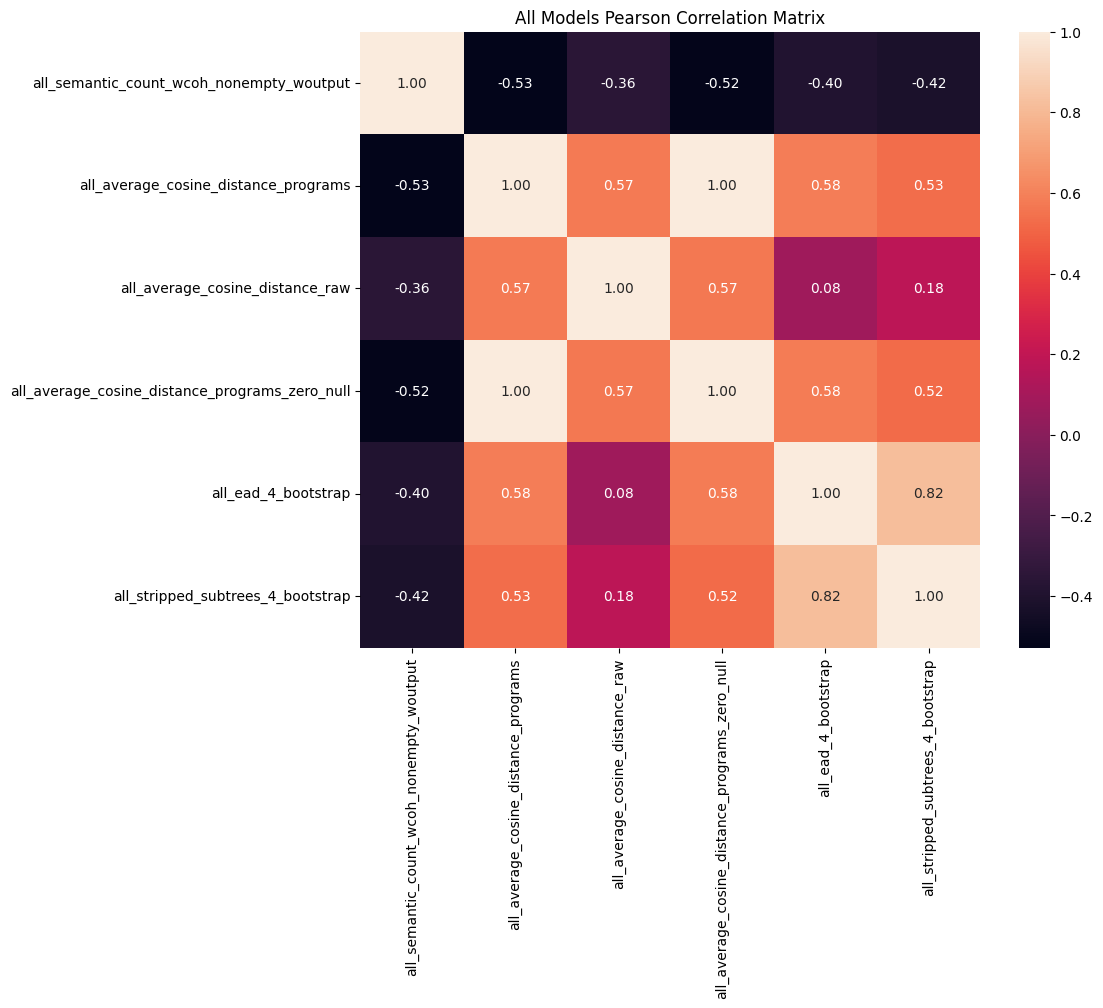

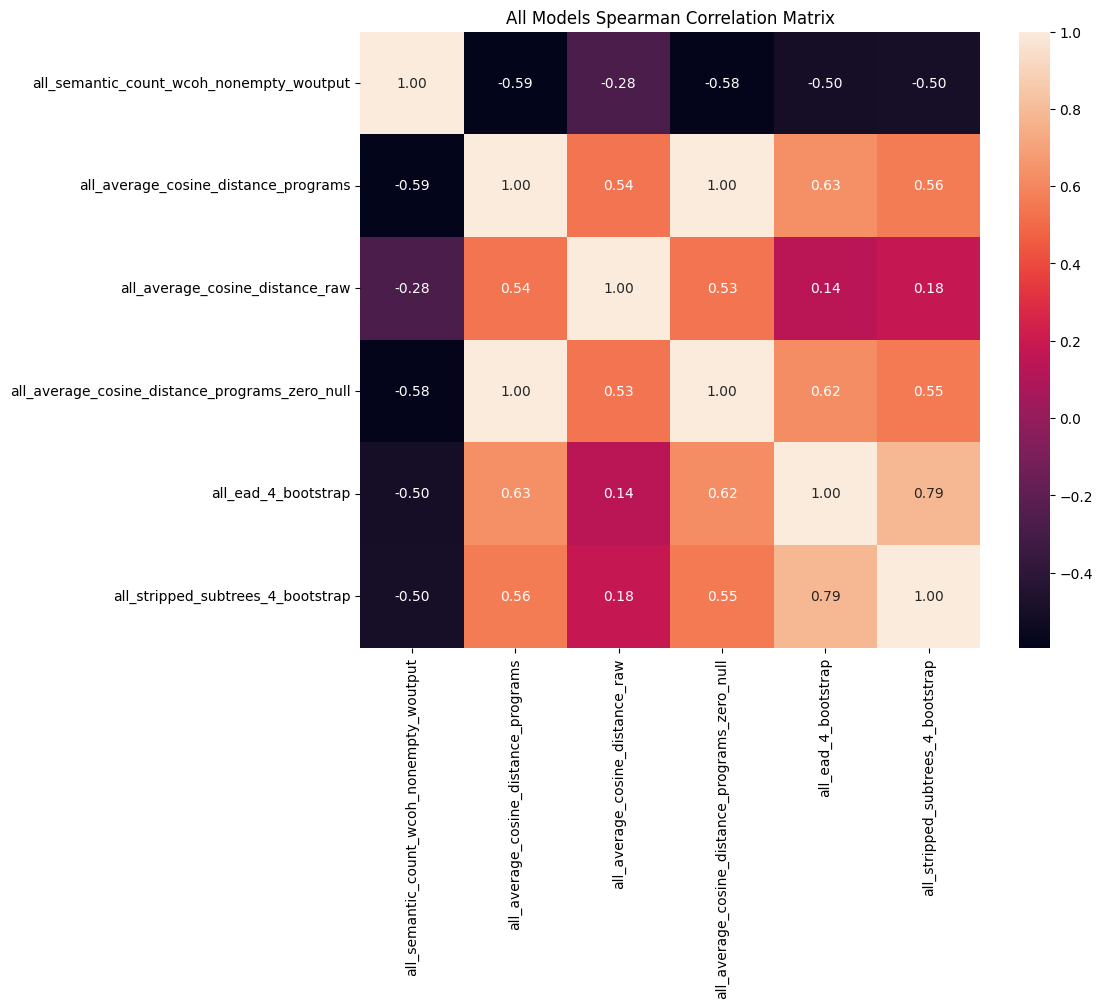

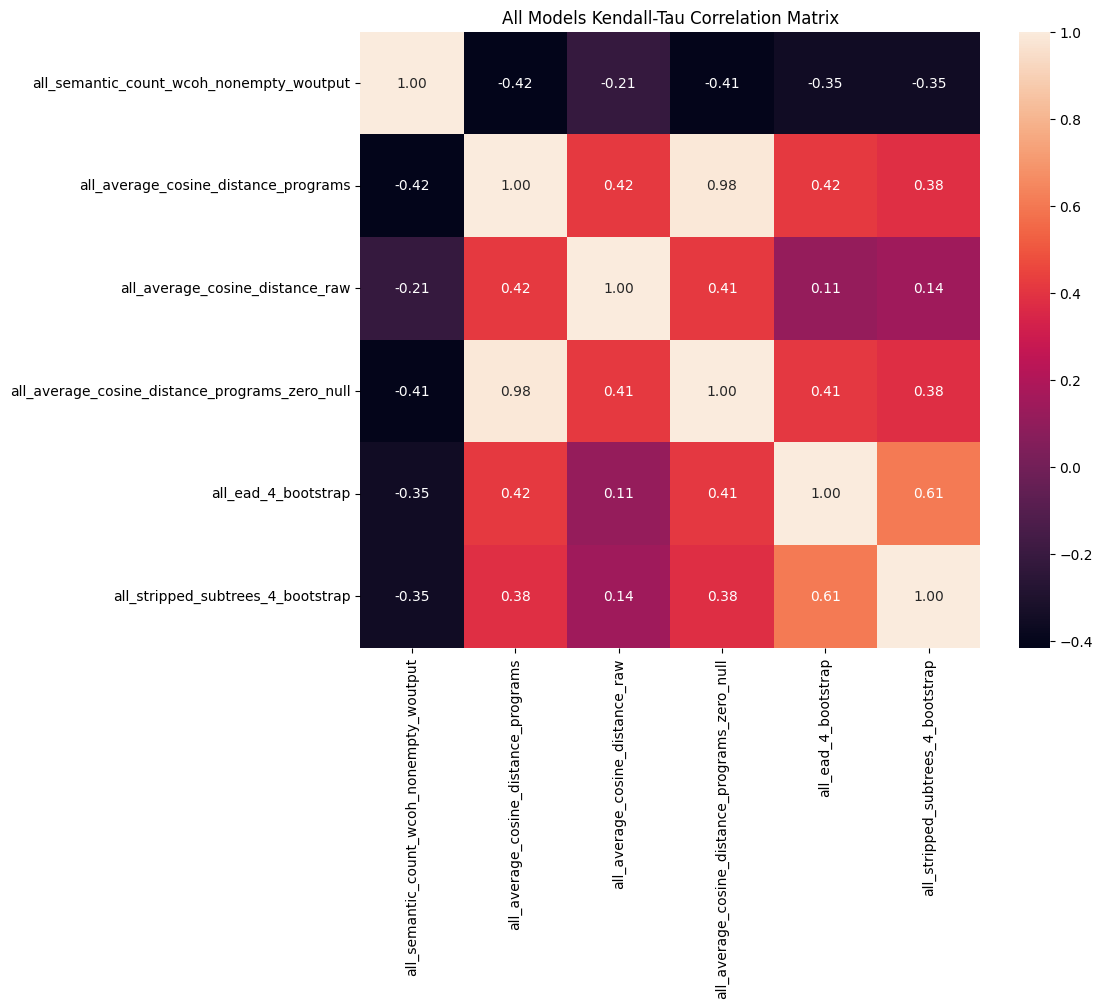

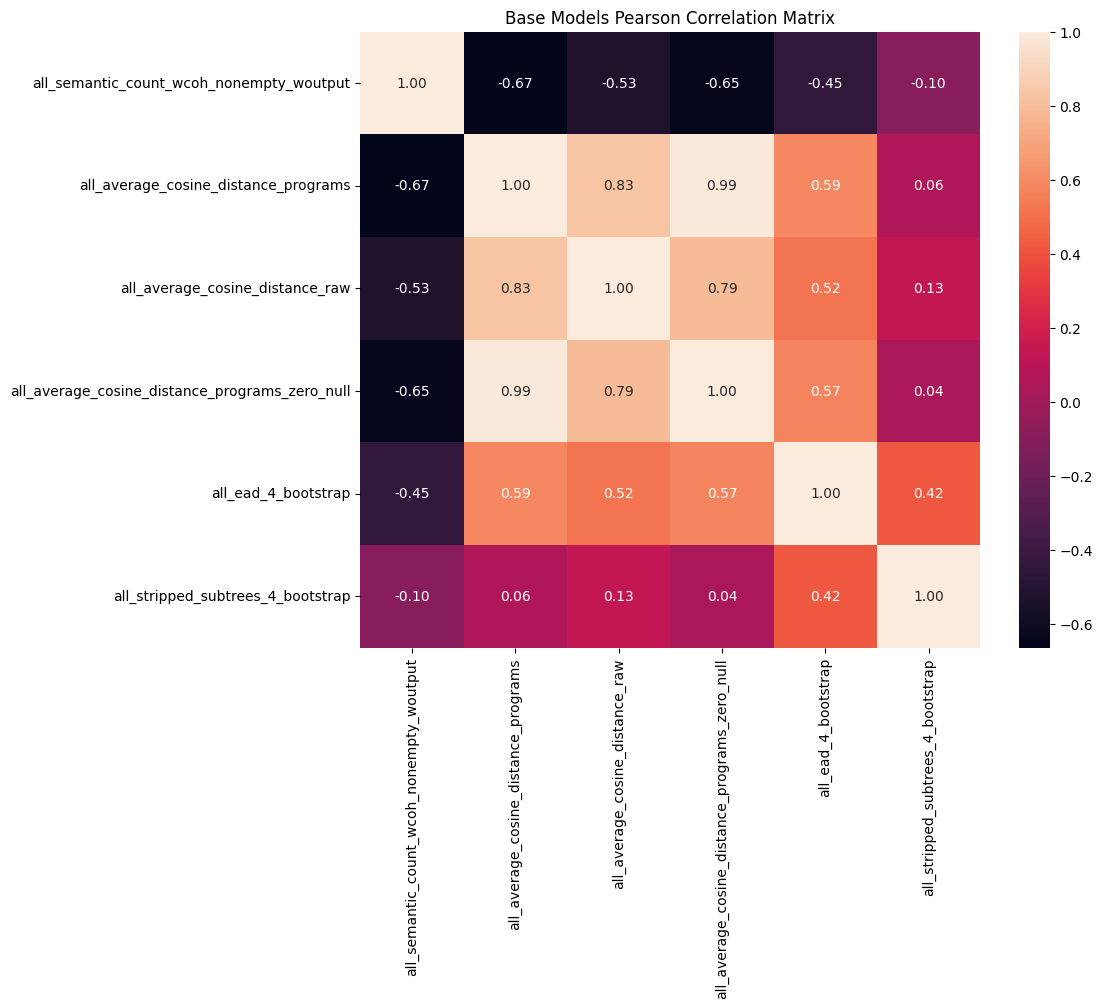

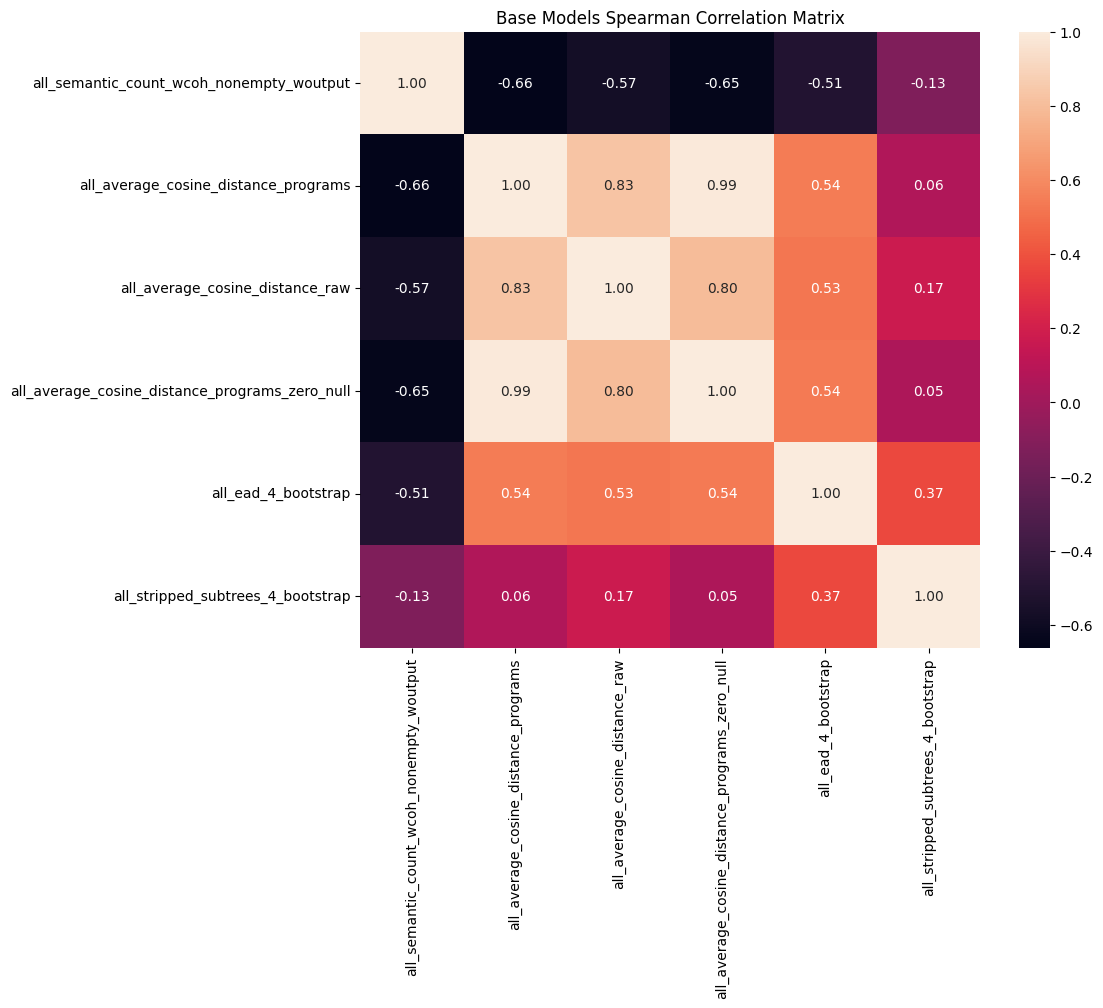

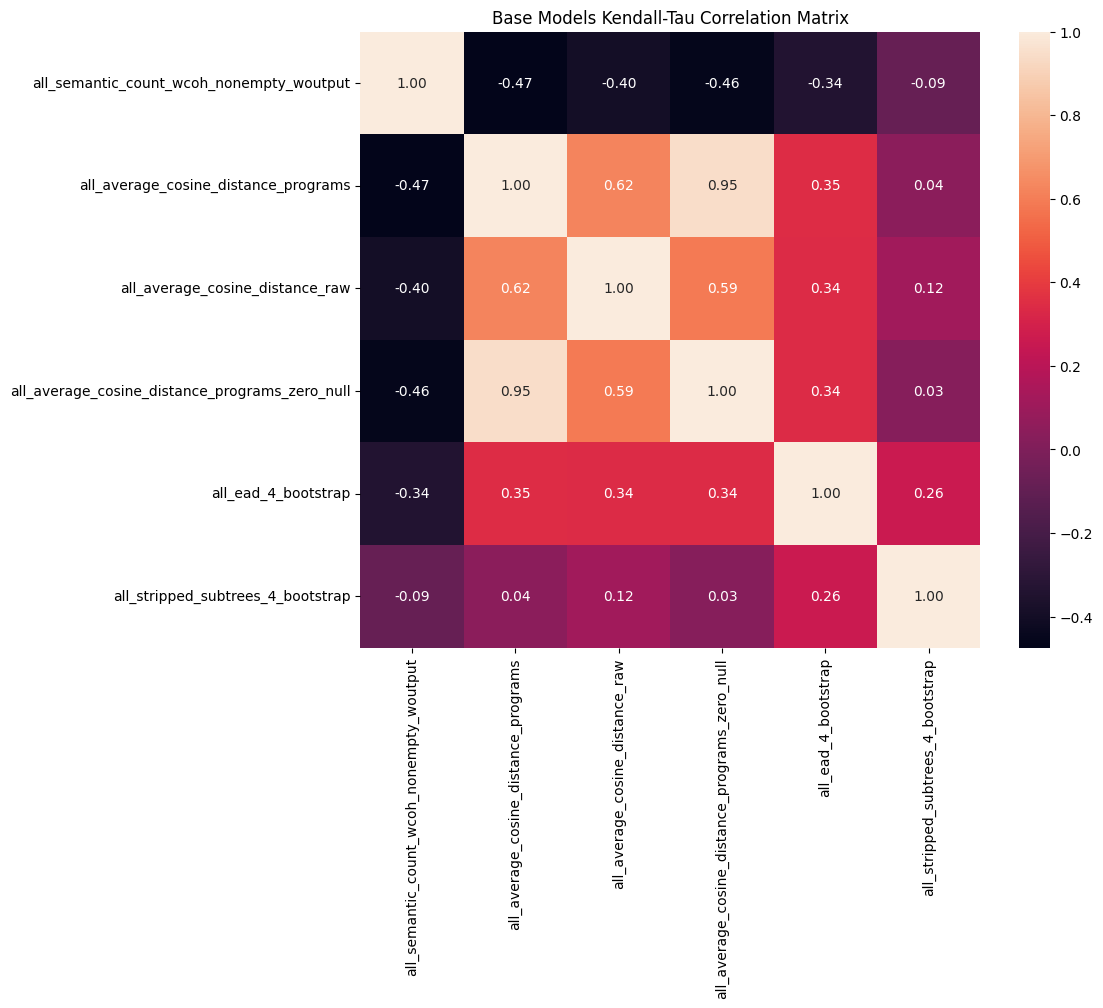

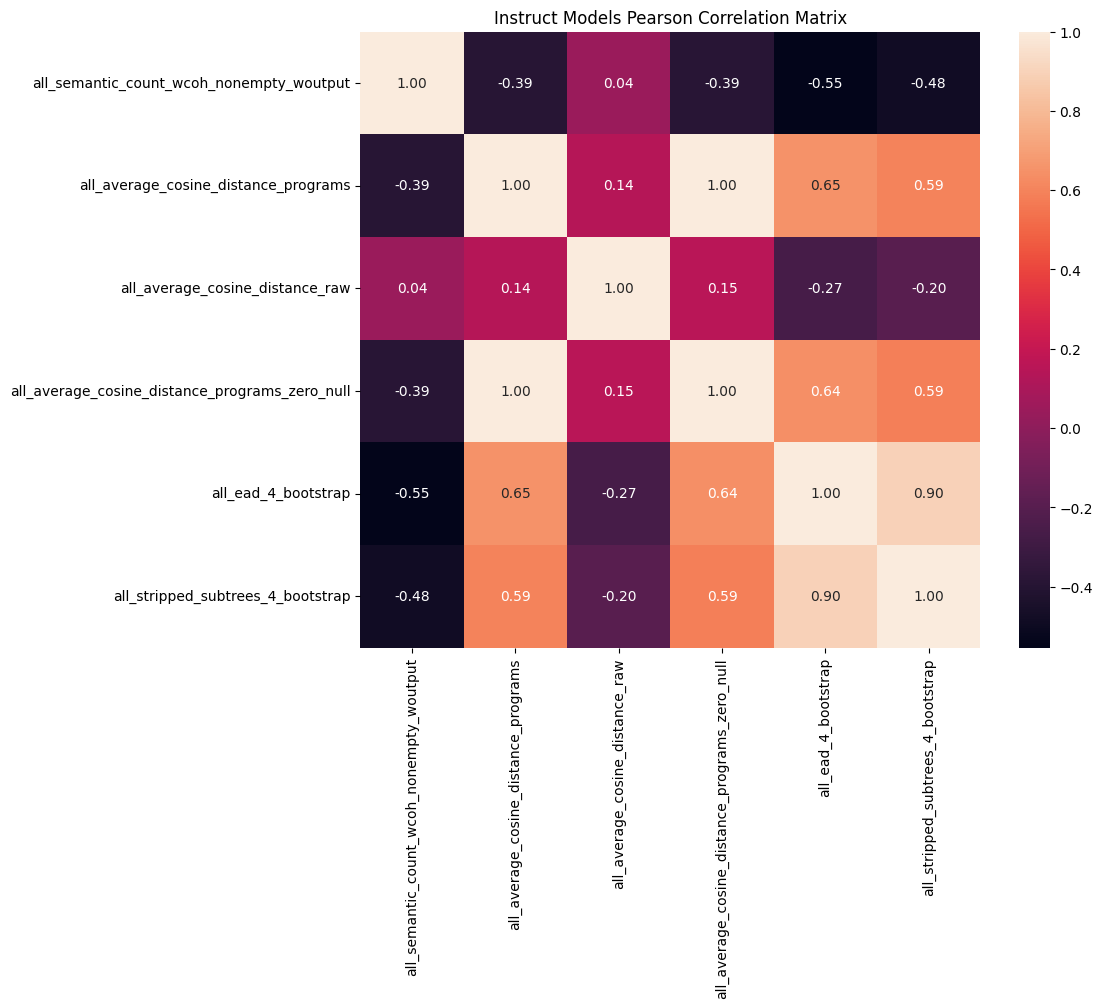

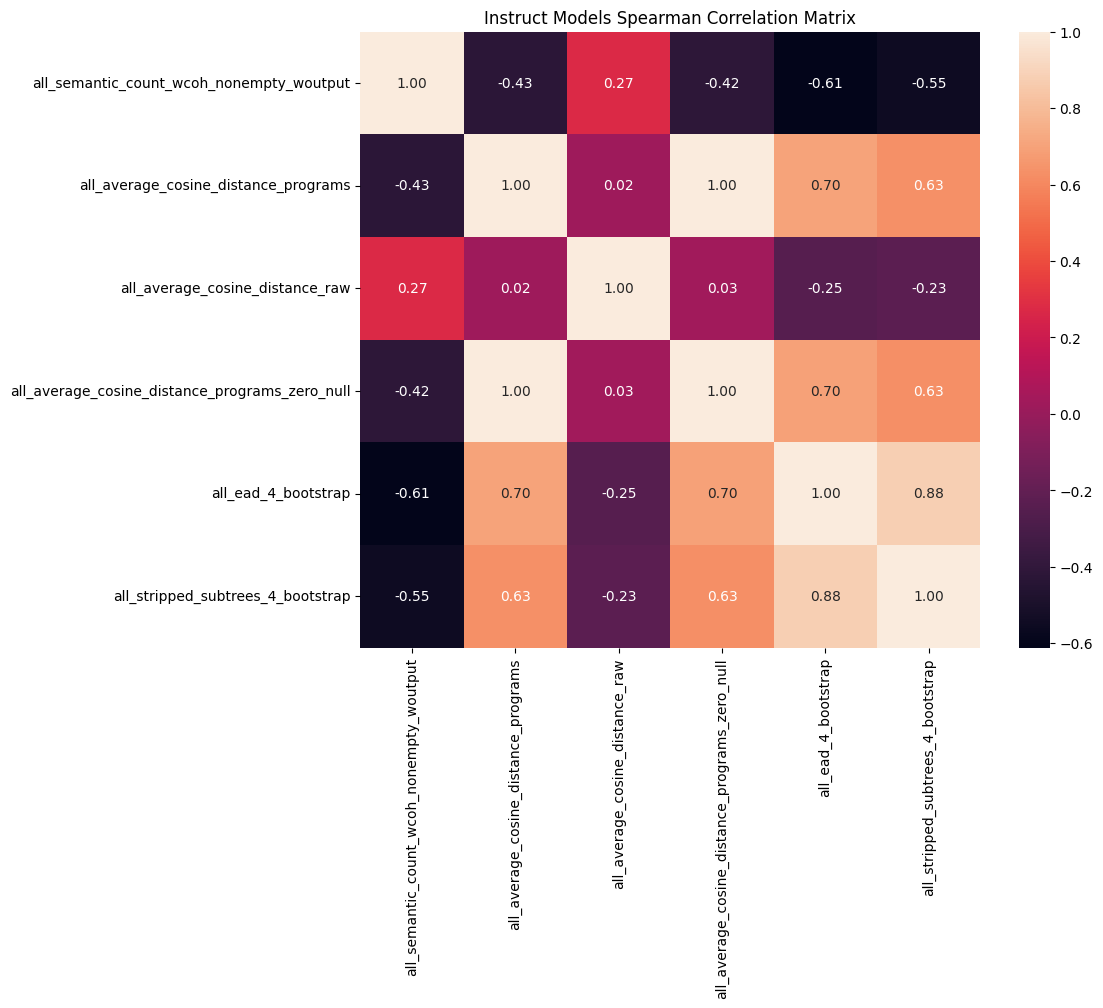

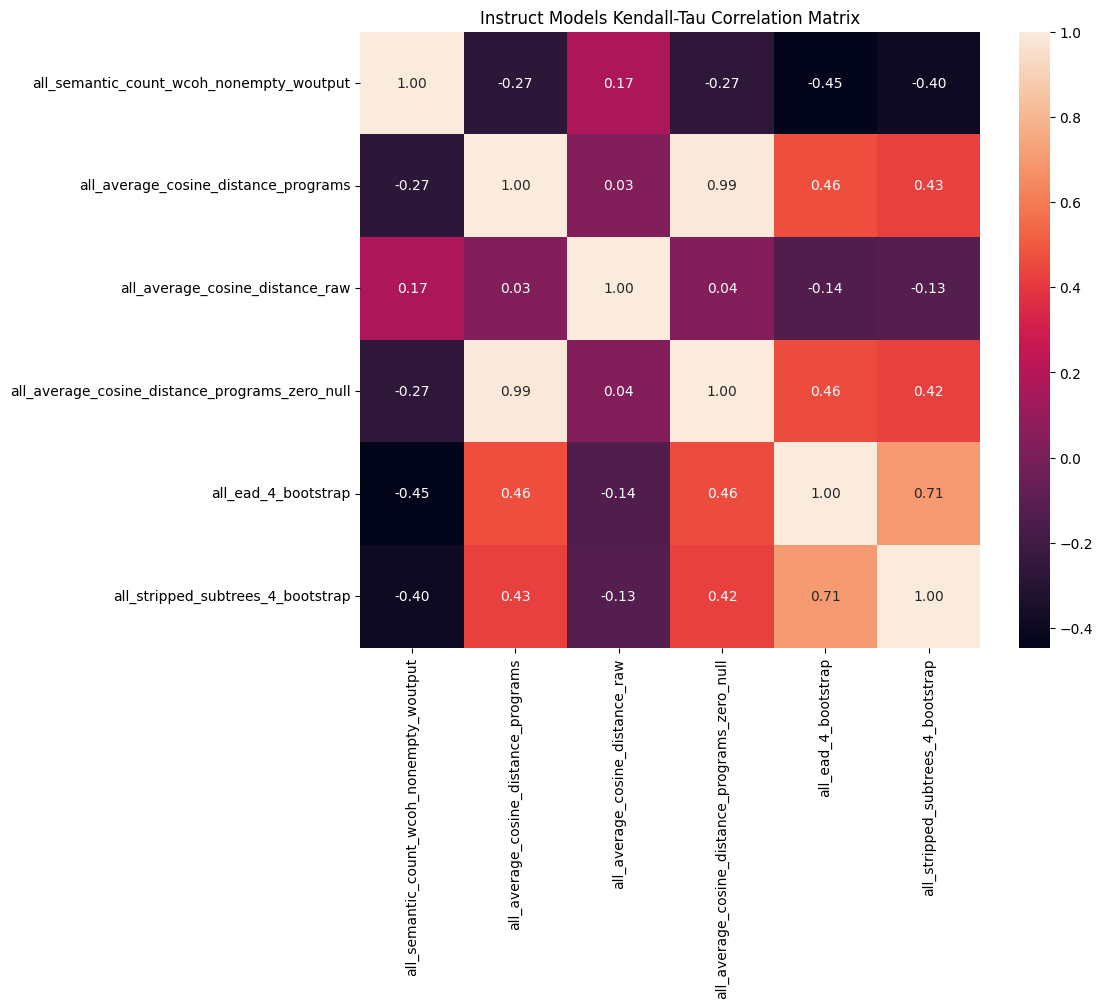

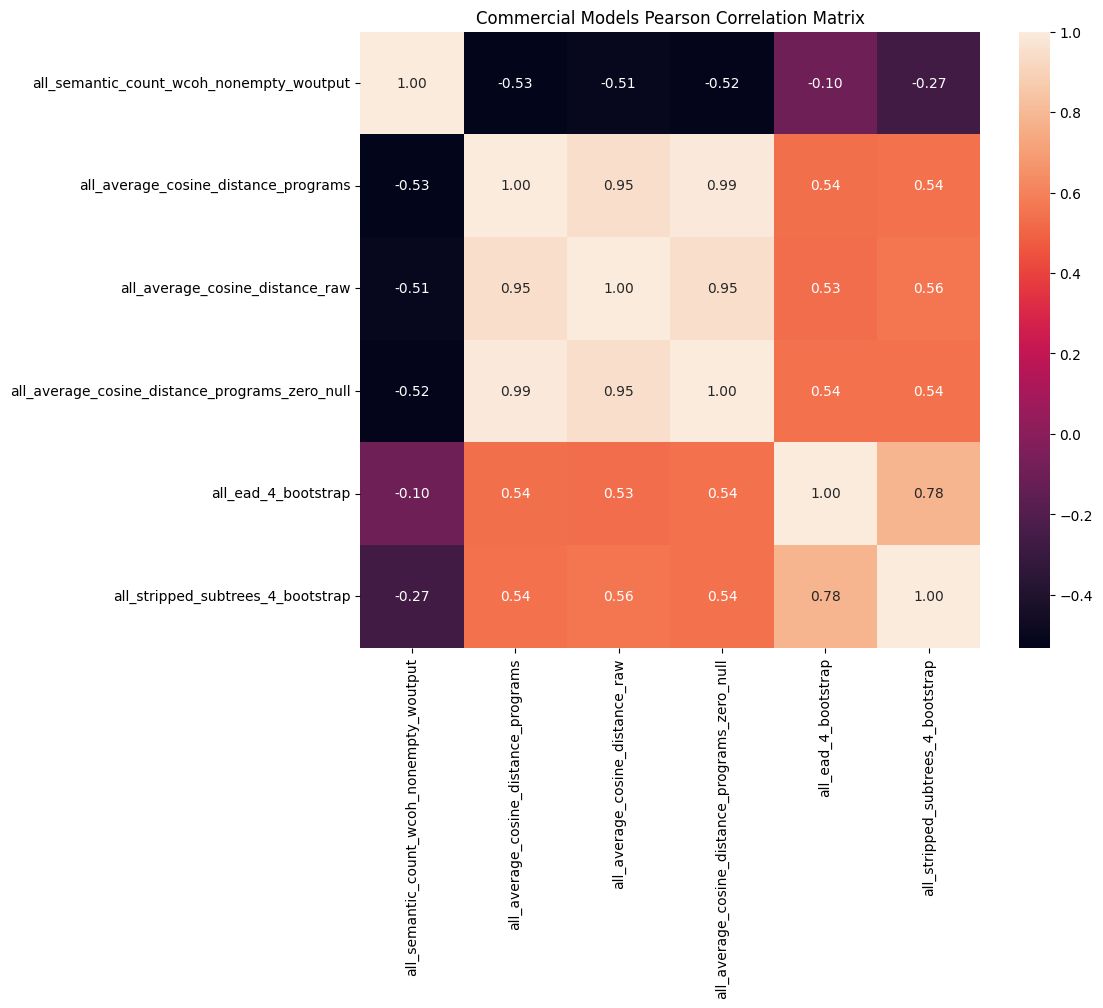

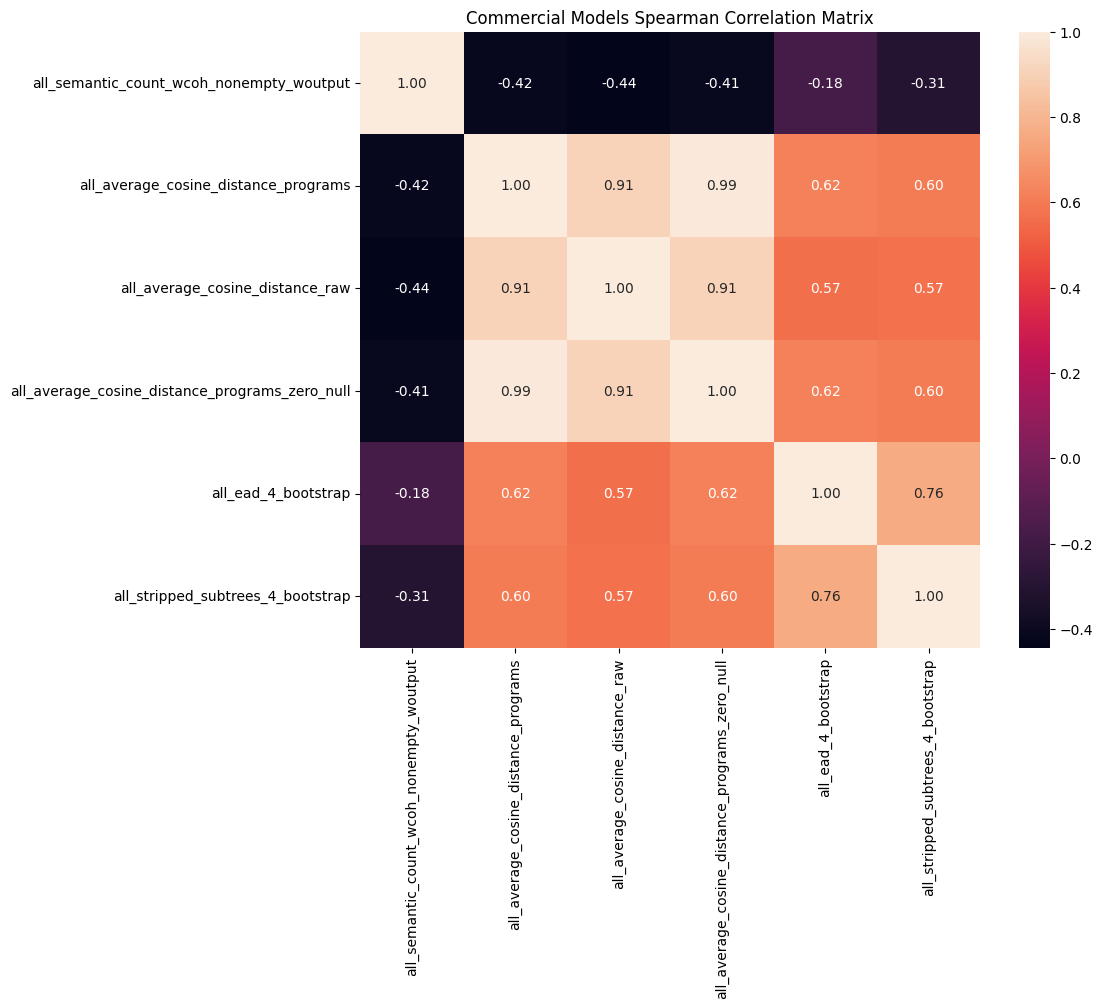

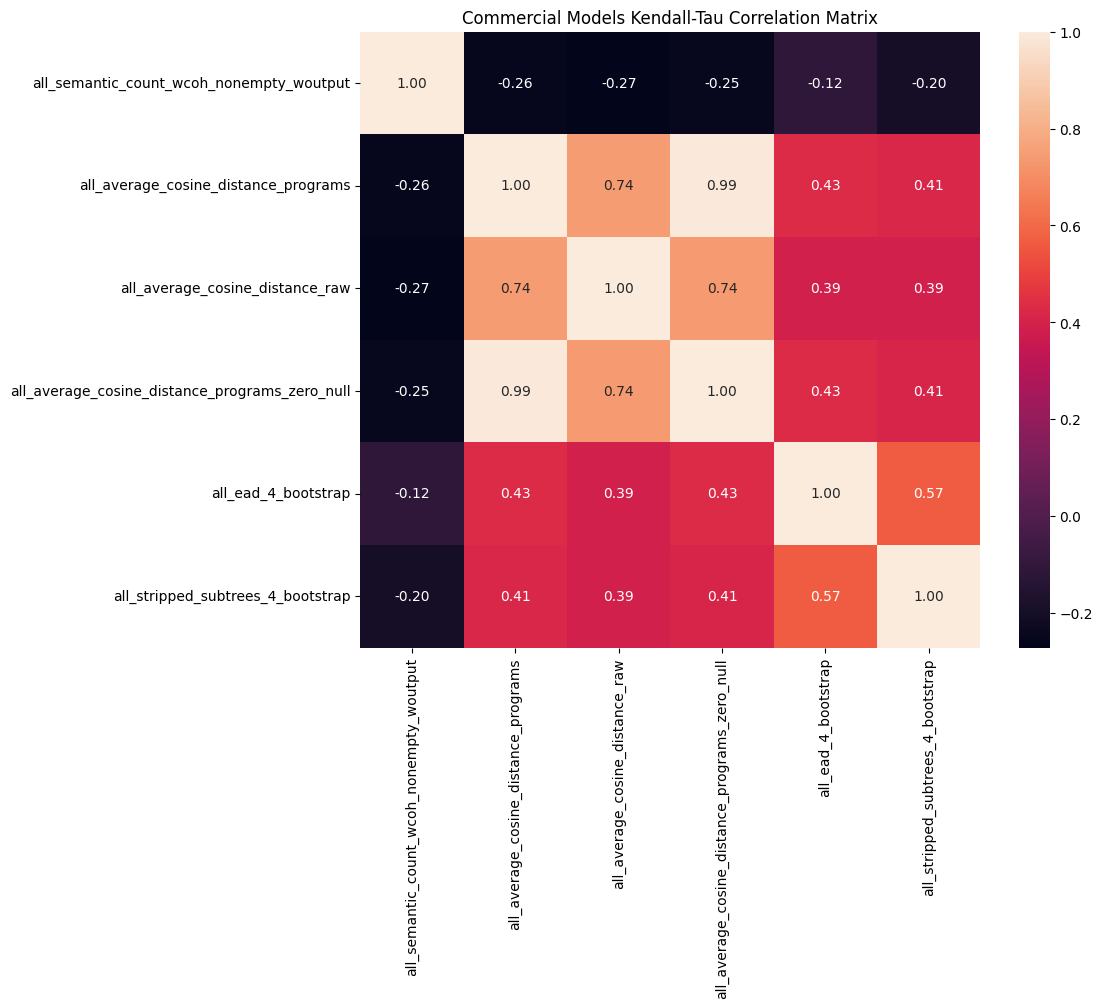

In [15]:
# All models
pearson_corr, spearman_corr, kendall_corr = correlation_analysis(filtered_result_dicts, key_columns)

plot_correlation_heatmap(pearson_corr, "All Models Pearson Correlation Matrix")
plot_correlation_heatmap(spearman_corr, "All Models Spearman Correlation Matrix")
plot_correlation_heatmap(kendall_corr, "All Models Kendall-Tau Correlation Matrix")

# Base models
pearson_corr, spearman_corr, kendall_corr = correlation_analysis(filtered_base_model_result_dicts, key_columns)

plot_correlation_heatmap(pearson_corr, "Base Models Pearson Correlation Matrix")
plot_correlation_heatmap(spearman_corr, "Base Models Spearman Correlation Matrix")
plot_correlation_heatmap(kendall_corr, "Base Models Kendall-Tau Correlation Matrix")

# Instruct models
pearson_corr, spearman_corr, kendall_corr = correlation_analysis(filtered_instruct_model_result_dicts, key_columns)

plot_correlation_heatmap(pearson_corr, "Instruct Models Pearson Correlation Matrix")
plot_correlation_heatmap(spearman_corr, "Instruct Models Spearman Correlation Matrix")
plot_correlation_heatmap(kendall_corr, "Instruct Models Kendall-Tau Correlation Matrix")

# Commercial models
pearson_corr, spearman_corr, kendall_corr = correlation_analysis(filtered_commercial_model_result_dicts, key_columns)

plot_correlation_heatmap(pearson_corr, "Commercial Models Pearson Correlation Matrix")
plot_correlation_heatmap(spearman_corr, "Commercial Models Spearman Correlation Matrix")
plot_correlation_heatmap(kendall_corr, "Commercial Models Kendall-Tau Correlation Matrix")